In [ ]:
!pip install -q -U "tensorflow-text==2.8.*"

In [ ]:
!pip install -q tf-models-official==2.7.0

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras import utils


import os
import re
import shutil
import string
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

tf.get_logger().setLevel('ERROR')

from tensorflow.keras import layers
from tensorflow.keras import losses


import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd
from google.colab import files

In [ ]:
!pip install datasets

In [ ]:
import datasets

In [ ]:
emotion_data = datasets.load_dataset('emotion')

Using custom data configuration default
Reusing dataset emotion (/root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
train_ds, val_ds, test_ds = emotion_data['train'],\
                             emotion_data['validation'], \
                             emotion_data['test']

In [ ]:
np.unique(train_ds['label'])

array([0, 1, 2, 3, 4, 5])

In [ ]:
train_text, train_labels = np.array(train_ds['text']), \
                            utils.to_categorical(train_ds['label'], 6)
val_text, val_labels = np.array(val_ds['text']), \
                            utils.to_categorical(val_ds['label'], 6)
test_text, test_labels = np.array(test_ds['text']), \
                            utils.to_categorical(test_ds['label'], 6)

In [ ]:
type(train_text)

numpy.ndarray

## Loading pre-trained BERT Model

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/4',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## Define our model

In [ ]:
def build_classifier_model(dropout_rate = 0.2):
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(dropout_rate)(net)
  net = tf.keras.layers.Dense(6, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

## Model Training

In [ ]:
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12' 

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

# bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
# bert_model = hub.KerasLayer(tfhub_handle_encoder)

classifier_model = build_classifier_model()

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
# loss and accuracy function

loss = tf.keras.losses.CategoricalCrossentropy(name = 'loss')
metrics = tf.metrics.CategoricalAccuracy(name = 'accuracy')

### Model 1

In [ ]:
# optimizer

epochs = 2
steps_per_epoch = len(train_ds)             # number of total batches
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_text, y = train_labels,
                               validation_data=(val_text, val_labels),
                               batch_size = 32,
                               validation_batch_size = 32,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
Epoch 1/2
500/500 [==============================] - 306s 577ms/step - loss: 0.4679 - binary_accuracy: 0.8308 - val_loss: 0.2755 - val_binary_accuracy: 0.8903
Epoch 2/2
500/500 [==============================] - 287s 574ms/step - loss: 0.1704 - binary_accuracy: 0.9417 - val_loss: 0.0812 - val_binary_accuracy: 0.9728


#### Loss Curve

In [ ]:
def plot_loss_curve(history):
    history_dict = history.history
    #print(history_dict.keys())

    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)
    fig = plt.figure(figsize=(8, 8))
    # fig.tight_layout()

    plt.subplot(2, 1, 1)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

In [ ]:
plot_loss_curve(history)

## Hyperparameter Optimization

In [ ]:
import numpy as np

In [ ]:
def get_random_params(params={}, lr_range = (-6, -3), 
                      drop_range = (0,0.4)):
    if 'dropout_rate' not in params.keys():
        params['dropout_rate'] = np.random.uniform(drop_range[0],drop_range[1])
    if 'init_lr' not in params.keys():
        params['init_lr'] = 10**np.random.uniform(lr_range[0],lr_range[1])
    return params

In [ ]:
params = get_random_params(params={'dropout_rate': 0.2})
params

{'dropout_rate': 0.2, 'init_lr': 2.167267771786838e-05}

In [ ]:
import time

In [ ]:
def run_NLP_model(params, epochs = 2, batch_size = 32):
    classifier_model =  build_classifier_model(params['dropout_rate'])

    steps_per_epoch = len(train_ds)             # number of total batches
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)

    optimizer = optimization.create_optimizer(init_lr=params['init_lr'],
                                            num_train_steps=num_train_steps,
                                            num_warmup_steps=num_warmup_steps,
                                            optimizer_type='adamw')
    classifier_model.compile(optimizer=optimizer,
                            loss=loss,
                            metrics=metrics)

    print(f'Training model with {tfhub_handle_encoder}')
    print(params)
    start_time = time.time()
    history = classifier_model.fit(x=train_text, y = train_labels,
                                   validation_data=(val_text, val_labels),
                                   batch_size = batch_size,
                                   validation_batch_size = batch_size,
                                   epochs=epochs)
    runtime = time.time() - start_time
    plot_loss_curve(history)
    val_acc = history.history['val_accuracy']

    return classifier_model, val_acc, runtime

### Original Bert (L=12, H=768, A=12) 

Learning Rate Primary Optimization

In [ ]:
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12' 

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
init_lr_list = np.array(10**np.linspace(-3,-6, 5), dtype='float32')
init_lr_list.dtype

dtype('float32')

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
{'dropout_rate': 0.2, 'init_lr': 0.001}
Epoch 1/2
500/500 [==============================] - 304s 580ms/step - loss: 0.7016 - accuracy: 0.5755 - val_loss: 0.2680 - val_accuracy: 0.9155
Epoch 2/2
500/500 [==============================] - 290s 581ms/step - loss: 0.3453 - accuracy: 0.8936 - val_loss: 0.3942 - val_accuracy: 0.8955


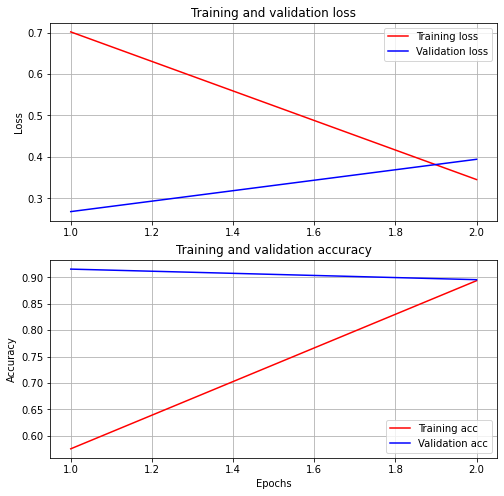

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
{'dropout_rate': 0.2, 'init_lr': 0.00017782794}
Epoch 1/2
500/500 [==============================] - 305s 582ms/step - loss: 0.9359 - accuracy: 0.6673 - val_loss: 0.2659 - val_accuracy: 0.9160
Epoch 2/2
500/500 [==============================] - 289s 579ms/step - loss: 0.2078 - accuracy: 0.9230 - val_loss: 0.1770 - val_accuracy: 0.9330


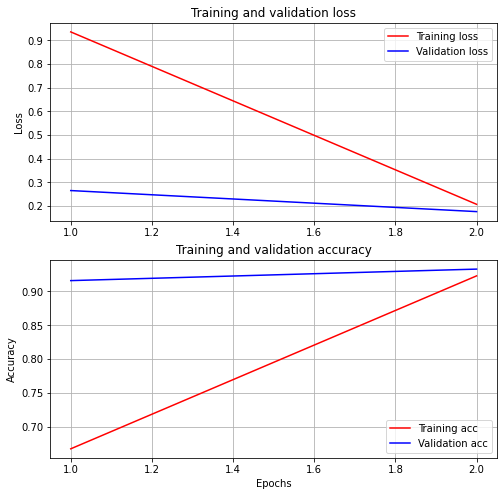

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
{'dropout_rate': 0.2, 'init_lr': 3.1622778e-05}
Epoch 1/2
500/500 [==============================] - 304s 580ms/step - loss: 1.5183 - accuracy: 0.4679 - val_loss: 0.9870 - val_accuracy: 0.6195
Epoch 2/2
500/500 [==============================] - 289s 578ms/step - loss: 0.5387 - accuracy: 0.8108 - val_loss: 0.2314 - val_accuracy: 0.9125


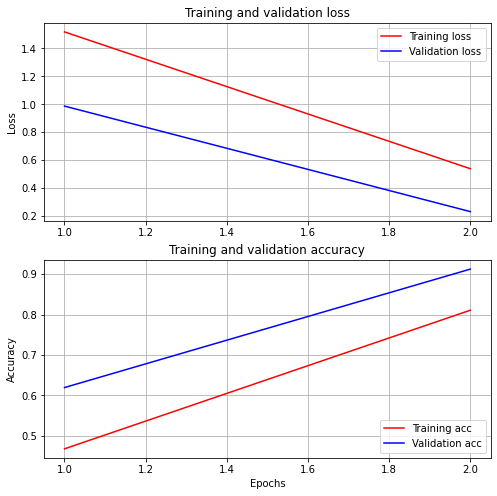

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
{'dropout_rate': 0.2, 'init_lr': 5.6234135e-06}
Epoch 1/2
500/500 [==============================] - 304s 580ms/step - loss: 1.8467 - accuracy: 0.3144 - val_loss: 1.5155 - val_accuracy: 0.4500
Epoch 2/2
500/500 [==============================] - 288s 576ms/step - loss: 1.4411 - accuracy: 0.4596 - val_loss: 1.1894 - val_accuracy: 0.5550


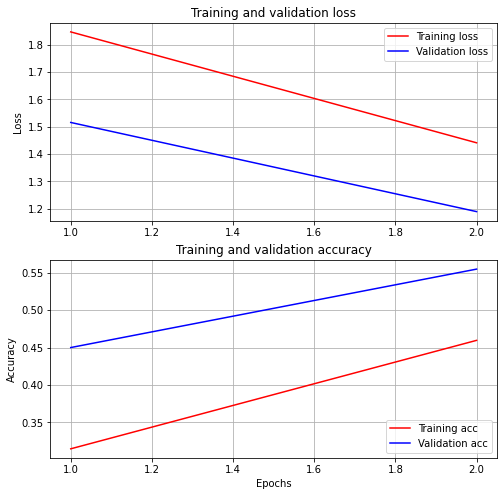

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
{'dropout_rate': 0.2, 'init_lr': 1e-06}
Epoch 1/2
500/500 [==============================] - 304s 578ms/step - loss: 2.1558 - accuracy: 0.1903 - val_loss: 1.9459 - val_accuracy: 0.1375
Epoch 2/2
500/500 [==============================] - 289s 579ms/step - loss: 1.8129 - accuracy: 0.2058 - val_loss: 1.6521 - val_accuracy: 0.2430


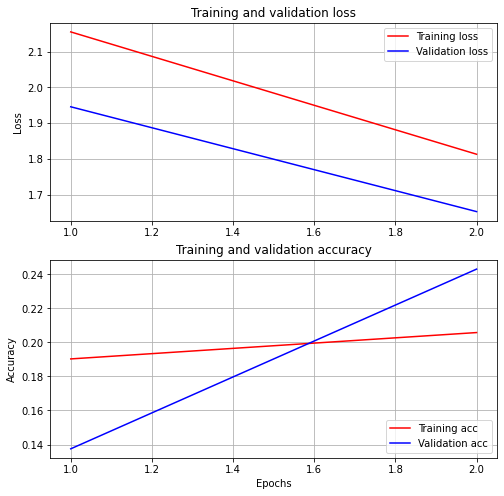

In [ ]:

classifier_model_list = []
val_acc_list = []
runtime_list = []
param_list = []

for i in range(5):
    params={'dropout_rate': 0.2, 'init_lr':init_lr_list[i]}
    param_list.append(params)

    classifier_model, val_acc, runtime = run_NLP_model(params)
    classifier_model_list.append(classifier_model)
    val_acc_list.append(val_acc[-1])
    runtime_list.append(runtime)

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


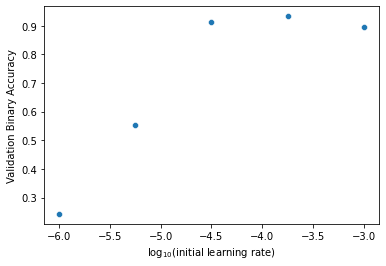

In [ ]:
sns.scatterplot(np.log10(init_lr_list), val_acc_list)
plt.xlabel('$\log_{10}$(initial learning rate)')
plt.ylabel('Validation Binary Accuracy')
plt.show()

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


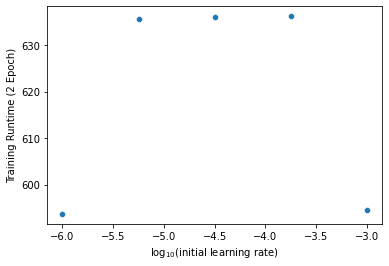

In [ ]:
sns.scatterplot(np.log10(init_lr_list), runtime_list)
plt.xlabel('$\log_{10}$(initial learning rate)')
plt.ylabel('Training Runtime (2 Epoch)')
plt.show()

## Random Search

More Granular Hyperparameter Search

In [ ]:
params = get_random_params(params = {}, lr_range = (-3.5,-5.5))
params

{'dropout_rate': 0.14406599176530097, 'init_lr': 6.832893309083587e-05}

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
{'dropout_rate': 0.05099428072664658, 'init_lr': 0.00046704307276544346}
Epoch 1/3
500/500 [==============================] - 306s 581ms/step - loss: 0.8542 - accuracy: 0.5755 - val_loss: 0.3145 - val_accuracy: 0.9020
Epoch 2/3
500/500 [==============================] - 289s 578ms/step - loss: 0.2098 - accuracy: 0.9261 - val_loss: 0.3312 - val_accuracy: 0.9115
Epoch 3/3
500/500 [==============================] - 286s 572ms/step - loss: 0.2035 - accuracy: 0.9283 - val_loss: 0.2813 - val_accuracy: 0.9110


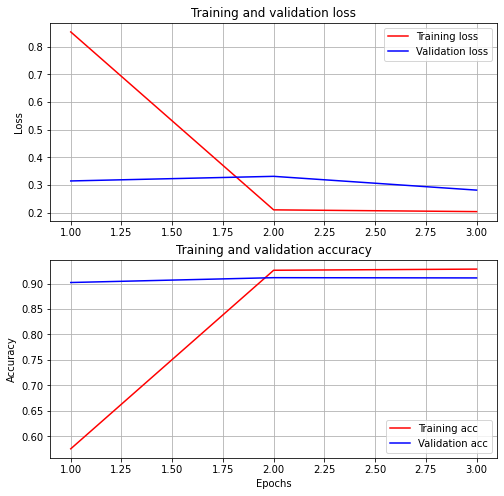

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
{'dropout_rate': 0.1660480098945968, 'init_lr': 5.11989756869343e-05}
Epoch 1/3
500/500 [==============================] - 302s 574ms/step - loss: 1.5095 - accuracy: 0.4839 - val_loss: 0.9943 - val_accuracy: 0.6375
Epoch 2/3
500/500 [==============================] - 286s 572ms/step - loss: 0.5512 - accuracy: 0.8081 - val_loss: 0.2532 - val_accuracy: 0.9105
Epoch 3/3
500/500 [==============================] - 286s 572ms/step - loss: 0.1972 - accuracy: 0.9251 - val_loss: 0.2221 - val_accuracy: 0.9250


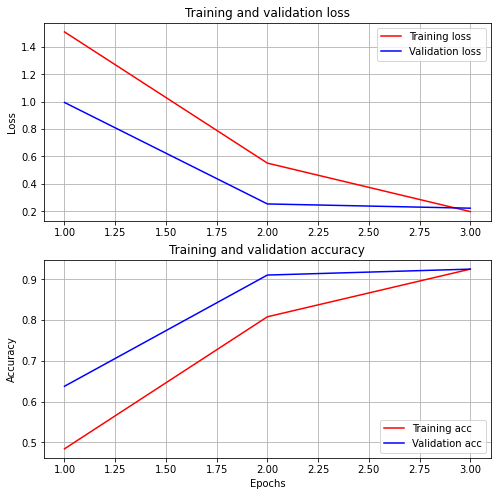

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
{'dropout_rate': 0.18735801558403353, 'init_lr': 0.00018453411779836406}
Epoch 1/3
500/500 [==============================] - 300s 574ms/step - loss: 1.0918 - accuracy: 0.6356 - val_loss: 0.2757 - val_accuracy: 0.9055
Epoch 2/3
500/500 [==============================] - 286s 572ms/step - loss: 0.2252 - accuracy: 0.9214 - val_loss: 0.1671 - val_accuracy: 0.9395
Epoch 3/3
500/500 [==============================] - 286s 573ms/step - loss: 0.1613 - accuracy: 0.9379 - val_loss: 0.1644 - val_accuracy: 0.9355


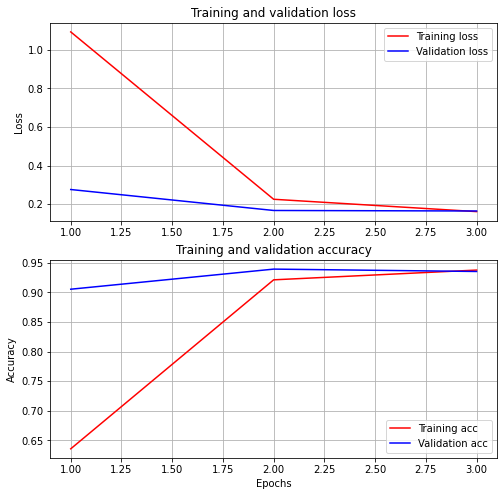

In [ ]:
classifier_model_list = []
val_acc_list = []
runtime_list = []
param_list = []

for i in range(3):
    params = get_random_params(params = {}, lr_range = (-3,-5))
    param_list.append(params)

    classifier_model, val_acc, runtime = run_NLP_model(params, epochs=3)
    classifier_model_list.append(classifier_model)
    val_acc_list.append(val_acc[-1])
    runtime_list.append(runtime)

In [ ]:
from google.colab import files
import pandas as pd 

df = pd.DataFrame.from_dict(param_list)
df['runtime'] = runtime_list
df['val_acc'] = val_acc_list
df['Model'] = classifier_model_list
df.to_csv("model_comparison.csv") 
files.download("model_comparison.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


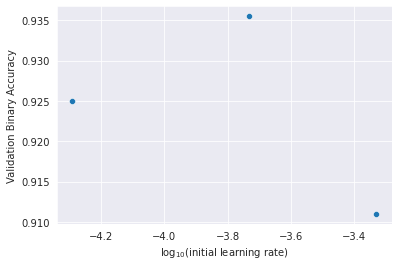

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


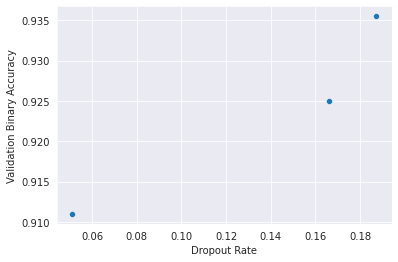

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


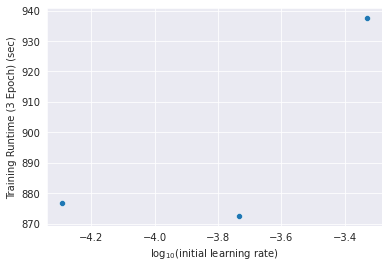

In [ ]:
sns.set_style('darkgrid')
sns.scatterplot(np.log10(df.init_lr), df.val_acc)
plt.xlabel('$\log_{10}$(initial learning rate)')
plt.ylabel('Validation Accuracy')
plt.show()

sns.scatterplot(df.dropout_rate, df.val_acc)
plt.xlabel('Dropout Rate')
plt.ylabel('Validation Accuracy')
plt.show()

sns.scatterplot(np.log10(df.init_lr), df.runtime)
plt.xlabel('$\log_{10}$(initial learning rate)')
plt.ylabel('Training Runtime (3 Epoch) (sec)')
plt.show()

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
{'dropout_rate': 0.07906002457220747, 'init_lr': 0.0001285341266808463}
Epoch 1/3
500/500 [==============================] - 301s 575ms/step - loss: 1.2562 - accuracy: 0.5791 - val_loss: 0.4245 - val_accuracy: 0.8570
Epoch 2/3
500/500 [==============================] - 286s 573ms/step - loss: 0.2582 - accuracy: 0.9076 - val_loss: 0.1685 - val_accuracy: 0.9340
Epoch 3/3
500/500 [==============================] - 287s 574ms/step - loss: 0.1431 - accuracy: 0.9401 - val_loss: 0.1720 - val_accuracy: 0.9350


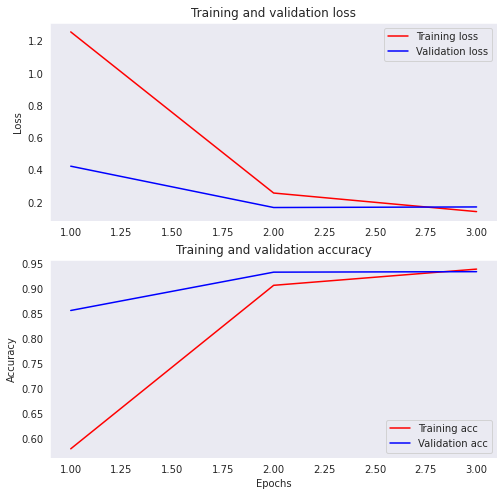

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
{'dropout_rate': 0.32630155040167663, 'init_lr': 0.00015524223474953997}
Epoch 1/3
500/500 [==============================] - 302s 575ms/step - loss: 1.2369 - accuracy: 0.5712 - val_loss: 0.3468 - val_accuracy: 0.8840
Epoch 2/3
500/500 [==============================] - 288s 576ms/step - loss: 0.2502 - accuracy: 0.9132 - val_loss: 0.1700 - val_accuracy: 0.9335
Epoch 3/3
500/500 [==============================] - 288s 575ms/step - loss: 0.1611 - accuracy: 0.9369 - val_loss: 0.1839 - val_accuracy: 0.9295


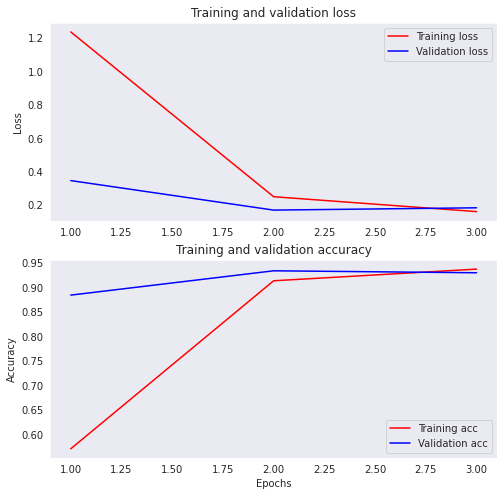

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
{'dropout_rate': 0.26131226899017096, 'init_lr': 0.00010874728546708444}
Epoch 1/3
500/500 [==============================] - 312s 586ms/step - loss: 1.3588 - accuracy: 0.5258 - val_loss: 0.4733 - val_accuracy: 0.8395
Epoch 2/3
500/500 [==============================] - 292s 584ms/step - loss: 0.2918 - accuracy: 0.8958 - val_loss: 0.1854 - val_accuracy: 0.9290
Epoch 3/3
500/500 [==============================] - 292s 583ms/step - loss: 0.1643 - accuracy: 0.9376 - val_loss: 0.1694 - val_accuracy: 0.9395


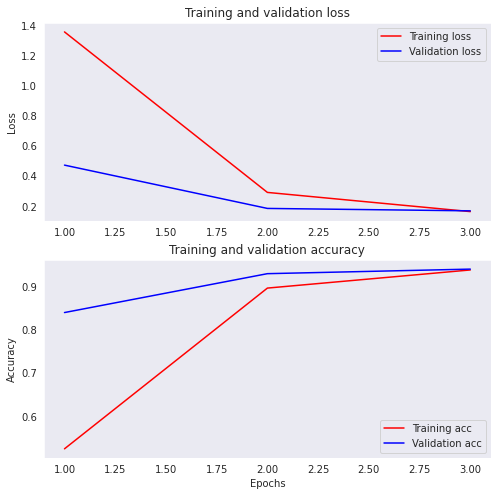

In [ ]:
classifier_model_list = []
val_acc_list = []
runtime_list = []
param_list = []

for i in range(3):
    params = get_random_params(params = {}, lr_range = (-3,-5))
    param_list.append(params)

    classifier_model, val_acc, runtime = run_NLP_model(params, epochs=3)
    classifier_model_list.append(classifier_model)
    val_acc_list.append(val_acc[-1])
    runtime_list.append(runtime)

In [ ]:
from google.colab import files
import pandas as pd 

df = pd.DataFrame.from_dict(param_list)
df['runtime'] = runtime_list
df['val_acc'] = val_acc_list
df['Model'] = classifier_model_list
df.to_csv("model_comparison.csv") 
files.download("model_comparison.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
sns.set_style('darkgrid')
sns.scatterplot(np.log10(df.init_lr), df.val_acc)
plt.xlabel('$\log_{10}$(initial learning rate)')
plt.ylabel('Validation Accuracy')
plt.show()

sns.scatterplot(df.dropout_rate, df.val_acc)
plt.xlabel('Dropout Rate')
plt.ylabel('Validation Accuracy')
plt.show()

sns.scatterplot(np.log10(df.init_lr), df.runtime)
plt.xlabel('$\log_{10}$(initial learning rate)')
plt.ylabel('Training Runtime (3 Epoch) (sec)')
plt.show()

In [ ]:
df = pd.read_csv("model_comparison_emotion.csv")
df.iloc[:, 1:5]

dropout_rate   init_lr      runtime  val_acc
0       0.050994  0.000467   937.502456   0.9110
1       0.166048  0.000051   876.615002   0.9250
2       0.187358  0.000185   872.518326   0.9355
3       0.079060  0.000129   874.685729   0.9350
4       0.326302  0.000155   936.058333   0.9295
5       0.261312  0.000109   895.676686   0.9395
6       0.186133  0.000087  1482.930452   0.9370
7       0.170812  0.000021  1478.170190   0.9205
8       0.039383  0.000016  1479.382396   0.9035
9       0.047166  0.000434  1437.879212   0.9275
10      0.210300  0.000024  1477.420973   0.9255

In [ ]:
df.init_lr

0    0.000467
1    0.000051
2    0.000185
3    0.000129
4    0.000155
5    0.000109
6    0.000087
Name: init_lr, dtype: float64

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
{'dropout_rate': 0.18613286711097599, 'init_lr': 8.73306779336953e-05}
Epoch 1/3
500/500 [==============================] - 495s 948ms/step - loss: 1.3433 - accuracy: 0.4648 - val_loss: 0.5545 - val_accuracy: 0.8040
Epoch 2/3
500/500 [==============================] - 471s 941ms/step - loss: 0.3131 - accuracy: 0.8912 - val_loss: 0.1851 - val_accuracy: 0.9300
Epoch 3/3
500/500 [==============================] - 471s 941ms/step - loss: 0.1619 - accuracy: 0.9387 - val_loss: 0.1547 - val_accuracy: 0.9370


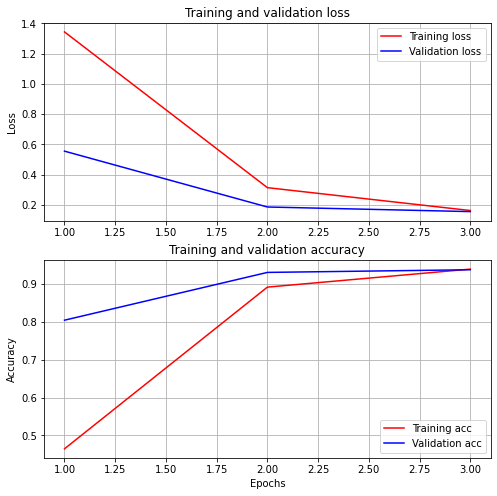

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
{'dropout_rate': 0.3403981130373744, 'init_lr': 0.0004287250977411069}
Epoch 1/3
 13/500 [..............................] - ETA: 7:18 - loss: 2.3801 - accuracy: 0.7988

KeyboardInterrupt: ignored

In [ ]:
classifier_model_list = list(df.Model)
val_acc_list = list(df.val_acc)
runtime_list = list(df.runtime)
param_list = list(df.iloc[:, 1:3].to_dict(orient='index').values())

for i in range(1):
    params = get_random_params(params = {}, lr_range = (-3,-5))
    param_list.append(params)

    classifier_model, val_acc, runtime = run_NLP_model(params, epochs=3)
    classifier_model_list.append(classifier_model)
    val_acc_list.append(val_acc[-1])
    runtime_list.append(runtime)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
{'dropout_rate': 0.17081230869065883, 'init_lr': 2.137352184770287e-05}
Epoch 1/3
500/500 [==============================] - 493s 951ms/step - loss: 1.7071 - accuracy: 0.3004 - val_loss: 1.3394 - val_accuracy: 0.5220
Epoch 2/3
500/500 [==============================] - 472s 943ms/step - loss: 0.8881 - accuracy: 0.6880 - val_loss: 0.4263 - val_accuracy: 0.8495
Epoch 3/3
500/500 [==============================] - 472s 943ms/step - loss: 0.3176 - accuracy: 0.8891 - val_loss: 0.2098 - val_accuracy: 0.9205


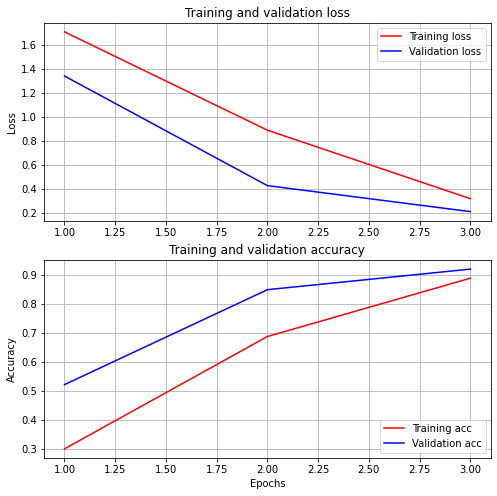

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
{'dropout_rate': 0.03938299598050468, 'init_lr': 1.5670710018299503e-05}
Epoch 1/3
500/500 [==============================] - 491s 948ms/step - loss: 1.5982 - accuracy: 0.4398 - val_loss: 1.3594 - val_accuracy: 0.5160
Epoch 2/3
500/500 [==============================] - 472s 945ms/step - loss: 1.0661 - accuracy: 0.6240 - val_loss: 0.6917 - val_accuracy: 0.7455
Epoch 3/3
500/500 [==============================] - 472s 943ms/step - loss: 0.4821 - accuracy: 0.8335 - val_loss: 0.2817 - val_accuracy: 0.9035


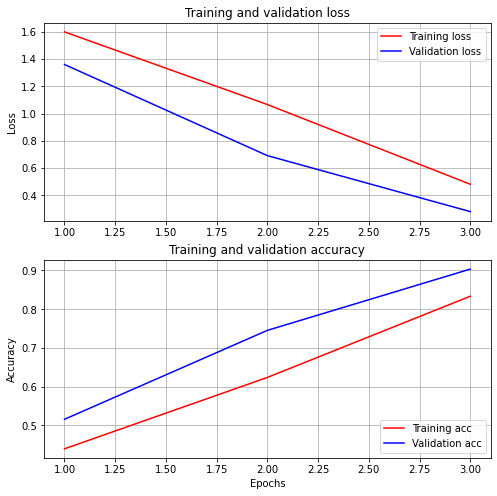

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
{'dropout_rate': 0.047166120066626994, 'init_lr': 0.0004343717062834166}
Epoch 1/3
500/500 [==============================] - 490s 949ms/step - loss: 0.8661 - accuracy: 0.7033 - val_loss: 0.2519 - val_accuracy: 0.9245
Epoch 2/3
500/500 [==============================] - 474s 948ms/step - loss: 0.2072 - accuracy: 0.9249 - val_loss: 0.1931 - val_accuracy: 0.9270
Epoch 3/3
500/500 [==============================] - 474s 947ms/step - loss: 0.2034 - accuracy: 0.9248 - val_loss: 0.2113 - val_accuracy: 0.9275


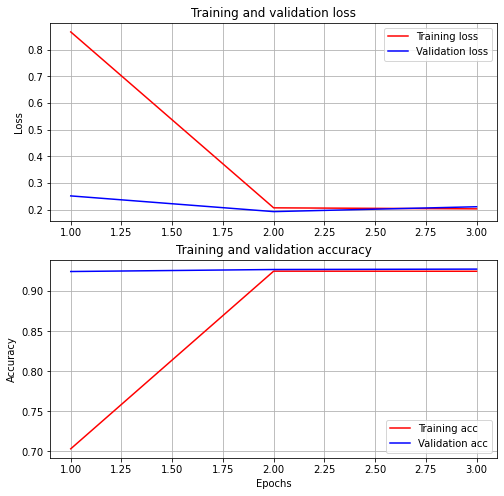

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
{'dropout_rate': 0.2103000908293632, 'init_lr': 2.3626391762763174e-05}
Epoch 1/3
500/500 [==============================] - 491s 950ms/step - loss: 1.7012 - accuracy: 0.3689 - val_loss: 1.2910 - val_accuracy: 0.5285
Epoch 2/3
500/500 [==============================] - 473s 947ms/step - loss: 0.9452 - accuracy: 0.6631 - val_loss: 0.4510 - val_accuracy: 0.8425
Epoch 3/3
500/500 [==============================] - 473s 946ms/step - loss: 0.3333 - accuracy: 0.8856 - val_loss: 0.1942 - val_accuracy: 0.9255


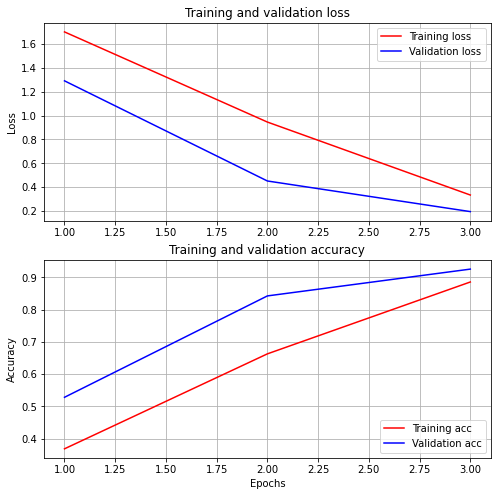

In [ ]:
classifier_model_list = list(df.Model)
val_acc_list = list(df.val_acc)
runtime_list = list(df.runtime)
param_list = list(df.iloc[:, :2].to_dict(orient='index').values())

for i in range(4):
    params = get_random_params(params = {}, lr_range = (-3,-5))
    param_list.append(params)

    classifier_model, val_acc, runtime = run_NLP_model(params, epochs=3)
    classifier_model_list.append(classifier_model)
    val_acc_list.append(val_acc[-1])
    runtime_list.append(runtime)

In [ ]:
param_list

[{'Unnamed: 0': 0, 'dropout_rate': 0.050994281},
 {'Unnamed: 0': 1, 'dropout_rate': 0.16604801},
 {'Unnamed: 0': 2, 'dropout_rate': 0.187358016},
 {'Unnamed: 0': 3, 'dropout_rate': 0.079060025},
 {'Unnamed: 0': 4, 'dropout_rate': 0.32630155},
 {'Unnamed: 0': 5, 'dropout_rate': 0.261312269},
 {'Unnamed: 0': 6, 'dropout_rate': 0.1861328671109759},
 {'dropout_rate': 0.17081230869065883, 'init_lr': 2.137352184770287e-05},
 {'dropout_rate': 0.03938299598050468, 'init_lr': 1.5670710018299503e-05},
 {'dropout_rate': 0.047166120066626994, 'init_lr': 0.0004343717062834166},
 {'dropout_rate': 0.2103000908293632, 'init_lr': 2.3626391762763174e-05}]

[{'dropout_rate': 0.050994281, 'init_lr': nan},
 {'dropout_rate': 0.16604801, 'init_lr': nan},
 {'dropout_rate': 0.187358016, 'init_lr': nan},
 {'dropout_rate': 0.079060025, 'init_lr': nan},
 {'dropout_rate': 0.32630155, 'init_lr': nan},
 {'dropout_rate': 0.261312269, 'init_lr': nan},
 {'dropout_rate': 0.1861328671109759, 'init_lr': nan}]

In [ ]:
param_list = list(df.iloc[:7, 1:3].to_dict(orient='index').values()) + param_list[-4:]

In [ ]:
pd.DataFrame.from_dict(param_list)

dropout_rate   init_lr
0       0.050994  0.000467
1       0.166048  0.000051
2       0.187358  0.000185
3       0.079060  0.000129
4       0.326302  0.000155
5       0.261312  0.000109
6       0.186133  0.000087
7       0.170812  0.000021
8       0.039383  0.000016
9       0.047166  0.000434
10      0.210300  0.000024

In [ ]:
from google.colab import files
import pandas as pd 

df = pd.DataFrame.from_dict(param_list)
df['runtime'] = runtime_list
df['val_acc'] = val_acc_list
df['Model'] = classifier_model_list
df.to_csv("model_comparison_emotion.csv") 
files.download("model_comparison_emotion.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


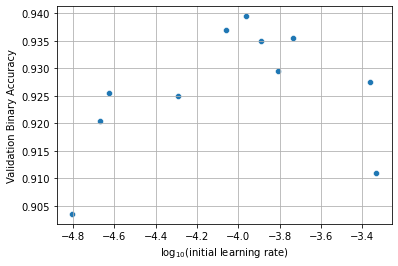

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


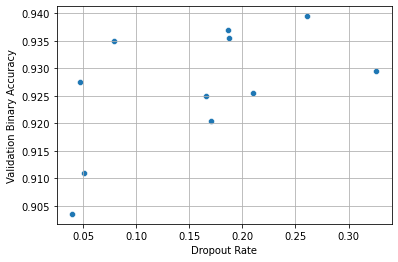

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


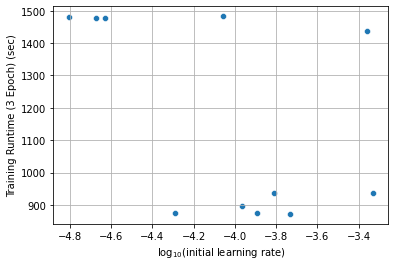

In [ ]:
sns.scatterplot(np.log10(df.init_lr), df.val_acc)
plt.xlabel('$\log_{10}$(initial learning rate)')
plt.ylabel('Validation Accuracy (After 3 epoch)')
plt.grid()
plt.show()

sns.scatterplot(df.dropout_rate, df.val_acc)
plt.xlabel('Dropout Rate')
plt.ylabel('Validation Accuracy (After 3 epoch)')
plt.grid()
plt.show()

sns.scatterplot(np.log10(df.init_lr), df.runtime)
plt.xlabel('$\log_{10}$(initial learning rate)')
plt.ylabel('Training Runtime (3 Epoch) (sec)')
plt.grid()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


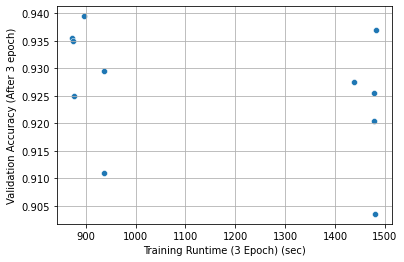

In [ ]:
sns.scatterplot(df.runtime, df.val_acc)
plt.ylabel('Validation Accuracy (After 3 epoch)')
plt.xlabel('Training Runtime (3 Epoch) (sec)')
plt.grid()
plt.show()

### Best Model

In [ ]:
df = pd.read_csv("model_comparison_emotion.csv")
df.iloc[:, 1:5]

dropout_rate   init_lr      runtime  val_acc
0       0.050994  0.000467   937.502456   0.9110
1       0.166048  0.000051   876.615002   0.9250
2       0.187358  0.000185   872.518326   0.9355
3       0.079060  0.000129   874.685729   0.9350
4       0.326302  0.000155   936.058333   0.9295
5       0.261312  0.000109   895.676686   0.9395
6       0.186133  0.000087  1482.930452   0.9370
7       0.170812  0.000021  1478.170190   0.9205
8       0.039383  0.000016  1479.382396   0.9035
9       0.047166  0.000434  1437.879212   0.9275
10      0.210300  0.000024  1477.420973   0.9255

In [ ]:
best_ind = df.val_acc.idxmax()
df.iloc[best_ind, :]

Unnamed: 0                                                      5
dropout_rate                                             0.261312
init_lr                                                  0.000109
runtime                                                895.676686
val_acc                                                    0.9395
Model           <keras.engine.functional.Functional object at ...
Name: 5, dtype: object

In [ ]:
best_params = {'dropout_rate': df.dropout_rate[best_ind].astype('float32'),
               'init_lr':df.init_lr[best_ind].astype('float32')}
best_params

{'dropout_rate': 0.26131228, 'init_lr': 0.000108747}

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
{'dropout_rate': 0.26131228, 'init_lr': 0.000108747}
Epoch 1/5
500/500 [==============================] - 491s 947ms/step - loss: 1.4680 - accuracy: 0.4371 - val_loss: 0.7380 - val_accuracy: 0.7475
Epoch 2/5
500/500 [==============================] - 471s 943ms/step - loss: 0.4177 - accuracy: 0.8554 - val_loss: 0.2066 - val_accuracy: 0.9245
Epoch 3/5
500/500 [==============================] - 471s 943ms/step - loss: 0.1763 - accuracy: 0.9329 - val_loss: 0.1721 - val_accuracy: 0.9335
Epoch 4/5
500/500 [==============================] - 471s 943ms/step - loss: 0.1336 - accuracy: 0.9451 - val_loss: 0.1817 - val_accuracy: 0.9320
Epoch 5/5
500/500 [==============================] - 471s 943ms/step - loss: 0.1138 - accuracy: 0.9511 - val_loss: 0.1741 - val_accuracy: 0.9345


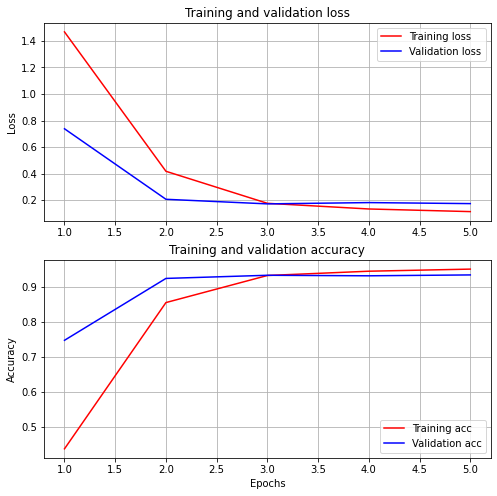

([0.7475000023841858,
  0.9244999885559082,
  0.9334999918937683,
  0.9319999814033508,
  0.934499979019165],
 2378.613920688629)

In [ ]:
best_classifier_model, best_val_acc, best_runtime = run_NLP_model(best_params, 
                                                             epochs = 5, 
                                                             batch_size = 32)
best_val_acc, best_runtime

In [ ]:
best_classifier_model.evaluate(x=test_text, y = test_labels)

63/63 [==============================] - 23s 357ms/step - loss: 0.2249 - accuracy: 0.9300


[0.22486640512943268, 0.9300000071525574]

In [ ]:
best_val_acc[-1], best_runtime/60.0

(0.934499979019165, 39.64356534481048)

In [ ]:
loss, accuracy = best_classifier_model.evaluate(x=test_text, 
                                                y = test_labels)


print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

63/63 [==============================] - 22s 347ms/step - loss: 0.2039 - accuracy: 0.9270
Loss: 0.20394672453403473
Accuracy: 0.9269999861717224


In [ ]:
emotion_label = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [ ]:
print(test_text[5])
print(emotion_label)
pred = best_classifier_model(test_text[5:6])[0]
ind = np.argmax(pred)
print(f'Emotion: {emotion_label[ind]}, score: {pred[ind]}')

i cant walk into a shop anywhere where i do not feel uncomfortable
['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
Emotion: fear, score: 0.9987987279891968


In [ ]:
my_text = 'I am finally finished with my assignment'
my_text = np.array([my_text])
print(my_text)
print(emotion_label)
pred = best_classifier_model(my_text[0:])[0]
ind = np.argmax(pred)
print(f'Emotion: {emotion_label[ind]}, score: {pred[ind]}')

['I am finally finished with my assignment']
['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
Emotion: joy, score: 0.9984484910964966


In [ ]:
my_text = 'I am in the mosque right now where everything is peaceful'
my_text = np.array([my_text])
print(my_text)
print(emotion_label)
pred = best_classifier_model(my_text[0:])[0]
ind = np.argmax(pred)
print(f'Emotion: {emotion_label[ind]}, score: {pred[ind]}')

['I am in the mosque right now where everything is peaceful']
['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
Emotion: joy, score: 0.999881386756897


### SHAP

In [ ]:
!pip install shap

     |████████████████████████████████| 564 kB 7.6 MB/s 


In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 10.5 MB/s 
     |████████████████████████████████| 6.6 MB 48.0 MB/s 
     |████████████████████████████████| 895 kB 10.3 MB/s 


In [ ]:
import shap
import transformers

In [ ]:
best_classifier_model(test_text[:2])

<tf.Tensor: shape=(2, 6), dtype=float32, numpy=
array([[9.9991977e-01, 4.7048714e-05, 6.9545267e-06, 1.1599509e-05,
        5.1632533e-06, 9.3699209e-06],
       [9.9996674e-01, 6.1579813e-06, 2.9066168e-06, 1.3005116e-05,
        5.2658947e-06, 5.9324907e-06]], dtype=float32)>

In [ ]:
# load the model and tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained("nateraw/bert-base-uncased-emotion")
model = transformers.AutoModelForSequenceClassification.from_pretrained("nateraw/bert-base-uncased-emotion")

# build a pipeline object to do predictions
pred = transformers.pipeline("text-classification", model=model, tokenizer=tokenizer, device=0, return_all_scores=True)

In [ ]:
explainer = shap.Explainer(pred)
#explainer = shap.Explainer(best_classifier_model)

In [ ]:
shap_values = explainer(test_text[:5])


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
You seem to be usin

In [ ]:
print(test_text[:5])
print(emotion_label)
pred = best_classifier_model(test_text[:5])
for i in range(5):
    ind = np.argmax(pred[i])
    print(f'Emotion: {emotion_label[ind]}, score: {pred[i][ind]} \n {pred[i]}')

['im feeling rather rotten so im not very ambitious right now'
 'im updating my blog because i feel shitty'
 'i never make her separate from me because i don t ever want her to feel like i m ashamed with her'
 'i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived'
 'i was feeling a little vain when i did this one']
['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
Emotion: sadness, score: 0.9999197721481323 
 [9.9991977e-01 4.7048536e-05 6.9545267e-06 1.1599497e-05 5.1632387e-06
 9.3699109e-06]
Emotion: sadness, score: 0.9999667406082153 
 [9.9996674e-01 6.1579867e-06 2.9066198e-06 1.3005128e-05 5.2658947e-06
 5.9324962e-06]
Emotion: sadness, score: 0.9999446868896484 
 [9.9994469e-01 1.3624980e-05 5.4901839e-06 7.8399280e-06 1.4447047e-05
 1.3930886e-05]
Emotion: joy, score: 0.9998997449874878 
 [1.2711084e-05 9.9989974e-01 6.1814411e-05 6.5825175e-06 9.6923986e-06
 9.3404078e-06]
Emotion: sadness, score: 0.99976354837

In [ ]:
shap.plots.text(shap_values)


In [ ]:
my_text = 'What I am doing with my life'
my_text = np.array([my_text])
shap_values = explainer(my_text[:1])


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
You seem to be usin

In [ ]:
shap.plots.text(shap_values)


In [ ]:
best_classifier_model(my_text[:1])

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[0.13060783, 0.45027584, 0.00491217, 0.35821584, 0.0495505 ,
        0.00643793]], dtype=float32)>